In [104]:
# Libraries
import pickle
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import math

In [105]:
# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda") # use GPU
else:
  device= torch.device("cpu")
print(device)

2.6.0+cu124
Tesla T4
cuda


In [106]:
Adj = torch.load('/kaggle/input/graphml/Adjacency.pt')
Adj= Adj.permute(1,2,0).contiguous().unsqueeze(dim=0).to(device)

num_nodes= Adj.shape[-2]

In [107]:
# Define Graph Transformer architecture
class head_attention(nn.Module):
    def __init__(self, d, d_head, dropout):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.E = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(dropout)
        self.Ni = nn.Linear(d, d_head)
        self.Nj = nn.Linear(d, d_head)

    def forward(self, x, e):
        Q = self.Q(x) # [bs, n, d_head]
        K = self.K(x) # [bs, n, d_head]
        V = self.V(x) # [bs, n, d_head]
        Q = Q.unsqueeze(2) # [bs, n, 1, d_head]
        K = K.unsqueeze(1) # [bs, 1, n, d_head]
        E = self.E(e) # [bs, n, n, d_head]
        Ni = self.Ni(x).unsqueeze(2) # [bs, n, 1, d_head]
        Nj = self.Nj(x).unsqueeze(1) # [bs, 1, n, d_head]
        e = Ni + Nj + E
        Att = (Q * e * K).sum(dim=3) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=1) # [bs, n, n]
        Att = self.drop_att(Att)
        x = Att @ V  # [bs, n, d_head]
        return x, e

In [108]:
class MHA(nn.Module):
    def __init__(self, d, num_heads, dropout):
        super().__init__()
        d_head = d // num_heads
        self.heads = nn.ModuleList([head_attention(d, d_head, dropout) for _ in range(num_heads)] )
        self.WOx = nn.Linear(d, d)
        self.WOe = nn.Linear(d, d)
        self.drop_x = nn.Dropout(dropout)
        self.drop_e = nn.Dropout(dropout)

    def forward(self, x, e):
        x_MHA = []
        e_MHA = []
        for head in self.heads:
            x_HA, e_HA = head(x,e)
            x_MHA.append(x_HA)
            e_MHA.append(e_HA)


        x = self.WOx(torch.cat(x_MHA, dim=2)) # [bs, n, d]
        x = self.drop_x(x)

        e = self.WOe(torch.cat(e_MHA, dim=3)) # [bs, n, n, d]
        e = self.drop_e(e)
        
        return x, e

In [109]:
class BlockGT(nn.Module):
    def __init__(self, d, num_heads, dropout):
        super().__init__()
        # Intialize two layer normalization for node features
        self.LNx = nn.LayerNorm(d)
        self.LNx2 = nn.LayerNorm(d)

        self.MLPx = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))

        self.MHA = MHA(d, num_heads, dropout)

        self.drop_x_mlp = nn.Dropout(dropout)

        self.LNe = nn.LayerNorm(d)
        self.LNe2 = nn.LayerNorm(d)

        self.MLPe = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))

        self.drop_x_mlp = nn.Dropout(dropout)
        self.drop_e_mlp = nn.Dropout(dropout)

    def forward(self, x, e):
        x = self.LNx(x)
        e = self.LNe(e)

        x_MHA, e_MHA = self.MHA(x, e) # [bs, n, d], [bs, n, n, d]

        x = x + x_MHA # [bs, n, d]
        x = x + self.MLPx(self.LNx2(x)) # [bs, n, d]

        x = self.drop_x_mlp(x)

        e = e + e_MHA
        e = e + self.MLPe(self.LNe2(e)) # [bs, n, n, d]
        e = self.drop_e_mlp(e)

        return x, e

In [110]:
def get_sinusoidal_positional_encoding(seq_len, d_model, device):
    """
    Creates sinusoidal positional encodings
    Args:
        seq_len: length of sequence (window_size)
        d_model: embedding dimension
        device: torch device
    Returns:
        positional encoding tensor of shape [seq_len, d_model]
    """
    position = torch.arange(seq_len, dtype=torch.float, device=device).unsqueeze(1)  # [seq_len, 1]
    div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float, device=device) * 
                         -(math.log(10000.0) / d_model))  # [d_model/2]
    
    pos_encoding = torch.zeros(seq_len, d_model, device=device)
    pos_encoding[:, 0::2] = torch.sin(position * div_term)  # Even indices
    pos_encoding[:, 1::2] = torch.cos(position * div_term)  # Odd indices
    
    return pos_encoding

In [111]:
class ConvNN(nn.Module):

    def __init__(self, window_size, output_size):

        super().__init__()
        self.conv= nn.Sequential(
            nn.LazyConv1d(64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.LazyBatchNorm1d(),
            nn.LazyConv1d(32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.LazyLinear(output_size)
        )
    
    def forward(self, x):
        return self.conv(x)

class SimpleNN(nn.Module):
    def __init__(self, inp_dim, hidden_dim, out_dim):

        super().__init__()

        self.MLP= nn.Sequential(
            nn.Linear(inp_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.MLP(x)


def sym_tensor(x):
    x = x.permute(0,3,1,2)
    triu = torch.triu(x,diagonal=1).transpose(3,2)
    mask = (triu.abs()>0).float()
    x =  x * (1 - mask ) + mask * triu
    x = x.permute(0,2,3,1)
    return x

class GT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config= config
        node_feat_dim= config['node_feat_dim']
        edge_feat_dim= config['edge_feat_dim']
        self.num_nodes= config['num_nodes']
        d= config['d']
        num_attn_heads= config['num_attn_heads']
        dropout= config['dropout']
        num_layers_encoder = config['num_layers']
        num_model_heads= config['num_model_heads']
        window_size= config['window_size']
        self.num_features= config['num_features']

        # self.node_emb = nn.ModuleList([ConvNN(window_size, d//self.num_features) for _ in range(self.num_features)])

        self.node_emb = nn.ModuleList([ConvNN(window_size, d) for _ in range(self.num_features)])

        self.Node_Embeddings= nn.Embedding(self.num_nodes, d)
        pos_emb = get_sinusoidal_positional_encoding(
                self.num_nodes, 
                self.config['d'], 
                device
            )
        self.Node_Embeddings.weight.data= pos_emb.clone()
        
        nn.init.constant_(self.Node_Embeddings.weight, 0)

        # self.Pos_Embeddings = nn.Embedding(window_size, d)  # ADD THIS LINE


        self.Edge_Embeddings= nn.Embedding(edge_feat_dim, d)

        self.BlockGT_encoder_layers = nn.ModuleList([BlockGT(d, num_attn_heads, dropout) for _ in range(num_layers_encoder)] )

        self.ln= nn.Sequential(nn.Linear(d, 4*d), nn.LayerNorm(4*d))
        self.Model_heads= nn.ModuleList([nn.Linear(4*d, 1) for _ in range(num_model_heads)])
        
        self.drop_x_emb = nn.Dropout(dropout)
        self.drop_e_emb = nn.Dropout(dropout)

    def forward(self, x, e):

        temp= []
        y_lin= x[:, :, :, 3].clone().squeeze().reshape(self.num_nodes, -1).float()
        y_lin.requires_grad_(requires_grad= False)
        for i in range(self.num_features):
            # Process feature through ConvNN
            feature_input = x[:, :, :, i].reshape(self.num_nodes, 1, -1)  # [num_nodes, 1, window_size]
            feature_emb = self.node_emb[i](feature_input).squeeze()  # [num_nodes, d]
            temp.append(feature_emb)
        
        # Aggregate all feature embeddings
        x = torch.stack(temp, dim=0).mean(dim=0).unsqueeze(dim=0)  # [1, num_nodes, d]
        
        # Add node-specific embeddings (which stock)
        x += self.Node_Embeddings(torch.arange(self.num_nodes, device=device)).unsqueeze(dim=0)  # [1, num_nodes, d]

        ## Sinusoidal PE
     
        e = e @ self.Edge_Embeddings.weight

        # e = sym_tensor(e)                      # [bs, n, n, d]
        x = self.drop_x_emb(x)
        e = self.drop_e_emb(e)

        # encoder
        for gt_layer in self.BlockGT_encoder_layers:
            x, e = gt_layer(x, e)  # [bs, n, d],  [bs, n, n, d]
            #e = sym_tensor(e)

        x= self.ln(x)
        
        # regressor
        out= torch.zeros(len(self.Model_heads), self.num_nodes, device= device)
        for i, head in enumerate(self.Model_heads):
            out[i, :]=   head(x).squeeze()
        return out

try:
    del net
except:
    print("First run")

In [112]:
window_size = 30
horizon = 7
Features= ['Open', 'High', 'Low', 'Close','Volume']#,'day_of_week','day_of_month','month','quarter']

# day_of_week	day_of_month	month	quarter

config={}
config['window_size']= window_size
config['num_features']= len(Features)
config['node_feat_dim']= window_size*len(Features)
config['edge_feat_dim']= 4
config['num_nodes']= num_nodes
config['d']= 128
config['num_attn_heads']= 8
config['dropout']= 0.1
config['num_layers']= 4
config['num_model_heads']= horizon

# Instantiate the network
net = GT(config)
net = net.to(device)

### DataLoader

In [113]:
import warnings
warnings.simplefilter('ignore')
df= pd.read_csv("/kaggle/input/gmldataset/final_data.csv")
df.head()

,Date,Ticker,Open,High,Low,Close,Volume,VIX_Open,VIX_High,VIX_Low,VIX_Close,return
0,2021-11-15,A,-0.065799,-0.067863,-0.070298,153.383484,-0.222001,-0.449280,-0.493175,-0.416336,-0.512960,NaN
1,2021-11-16,A,-0.076257,-0.066214,-0.071658,156.892868,-0.215434,-0.478901,-0.551531,-0.506668,-0.534248,0.022880
2,2021-11-17,A,-0.064131,-0.068873,-0.064253,157.038696,-0.232547,-0.566022,-0.534638,-0.457574,-0.402970,0.000929
3,2021-11-18,A,-0.062612,-0.066657,-0.062994,157.641403,-0.206982,-0.487613,-0.387213,-0.437937,-0.317817,0.003838
4,2021-11-19,A,-0.061417,-0.061118,-0.057277,159.721802,-0.199703,-0.391780,-0.255144,-0.271017,-0.261048,0.013197


In [114]:
df['Open'] = df['Open'].pct_change()
df['High'] = df['High'].pct_change()
df['Close'] = df['Close'].pct_change()
df['Low'] = df['Low'].pct_change()
df['Volume'] = df['Volume'].pct_change()

df= df.dropna()
df.head()

,Date,Ticker,Open,High,Low,Close,Volume,VIX_Open,VIX_High,VIX_Low,VIX_Close,return
1,2021-11-16,A,0.158937,-0.024302,0.019347,0.022880,-0.029581,-0.478901,-0.551531,-0.506668,-0.534248,0.022880
2,2021-11-17,A,-0.159017,0.040150,-0.103332,0.000929,0.079432,-0.566022,-0.534638,-0.457574,-0.402970,0.000929
3,2021-11-18,A,-0.023683,-0.032167,-0.019597,0.003838,-0.109935,-0.487613,-0.387213,-0.437937,-0.317817,0.003838
4,2021-11-19,A,-0.019090,-0.083092,-0.090757,0.013197,-0.035167,-0.391780,-0.255144,-0.271017,-0.261048,0.013197
5,2021-11-22,A,-0.080678,-0.024567,-0.004836,-0.009251,-0.098186,-0.245415,-0.166075,-0.247452,-0.037521,-0.009251


In [115]:
train_dfs = []
val_dfs = []

for ticker in df['Ticker'].unique():
    df_ticker = df[df['Ticker'] == ticker].sort_values('Date')
    n = len(df_ticker)
    split_idx = int(np.floor(0.85 * n))
    train_dfs.append(df_ticker.iloc[:split_idx])
    val_dfs.append(df_ticker.iloc[split_idx:])

train_df = pd.concat(train_dfs).reset_index(drop=True)
val_df = pd.concat(val_dfs).reset_index(drop=True)

In [116]:
train_df.head()

,Date,Ticker,Open,High,Low,Close,Volume,VIX_Open,VIX_High,VIX_Low,VIX_Close,return
0,2021-11-16,A,0.158937,-0.024302,0.019347,0.022880,-0.029581,-0.478901,-0.551531,-0.506668,-0.534248,0.022880
1,2021-11-17,A,-0.159017,0.040150,-0.103332,0.000929,0.079432,-0.566022,-0.534638,-0.457574,-0.402970,0.000929
2,2021-11-18,A,-0.023683,-0.032167,-0.019597,0.003838,-0.109935,-0.487613,-0.387213,-0.437937,-0.317817,0.003838
3,2021-11-19,A,-0.019090,-0.083092,-0.090757,0.013197,-0.035167,-0.391780,-0.255144,-0.271017,-0.261048,0.013197
4,2021-11-22,A,-0.080678,-0.024567,-0.004836,-0.009251,-0.098186,-0.245415,-0.166075,-0.247452,-0.037521,-0.009251


In [117]:
class StockChunksAllTickersDataset(Dataset):
    def __init__(self, df, chunk_size, allowed_features, chunk_start_idx=0):
        self.chunk_size = chunk_size  # e.g. 25
        self.allowed_features = allowed_features
        self.chunk_start_idx = chunk_start_idx

        self.tickers = df['Ticker'].unique()

        # Prepare chunk data for each ticker
        self.chunks_per_ticker = []
        grouped = df.groupby('Ticker')
        for ticker in self.tickers:
            group = grouped.get_group(ticker).sort_values('Date')
            data = group[self.allowed_features].values

            # Extract single chunk starting at chunk_start_idx (default 0)
            chunk = data[chunk_start_idx:chunk_start_idx + chunk_size]
            if len(chunk) < chunk_size:
                # If not enough data, pad with zeros (or handle differently)
                padding = np.zeros((chunk_size - len(chunk), len(self.allowed_features)))
                chunk = np.vstack([chunk, padding])
            self.chunks_per_ticker.append(chunk)

        # Stack into one tensor with shape (num_tickers, chunk_size, num_features)
        self.all_chunks = torch.tensor(self.chunks_per_ticker, dtype=torch.float32)

    def __len__(self):
        # Only one sample: all tickers' chunks together
        return 1

    def __getitem__(self, idx):
        return self.all_chunks


train_ds= StockChunksAllTickersDataset(train_df, chunk_size=window_size+horizon, allowed_features= Features)
train_dl= DataLoader(train_ds, batch_size=1, shuffle=False)

valid_ds= StockChunksAllTickersDataset(val_df, chunk_size=window_size+horizon, allowed_features= Features)
valid_dl= DataLoader(valid_ds, batch_size=1, shuffle=False)

### Training Code

In [118]:
# Calculate typical error magnitude from your data
# Use a simple baseline: predict next value = current value
sample_errors = []

for batch in train_dl:
    x = batch[:, :, :window_size, :]
    y = batch[:, :, window_size:, 3]  # Actual future close prices
    
    # Simple baseline: last known close price
    last_close = x[:, :, -1, 3]  # Last close in window
    
    # Calculate errors
    for h in range(horizon):
        errors = torch.abs(y[:, :, h] - last_close.squeeze())
        sample_errors.extend(errors.flatten().tolist())

# Calculate statistics
sample_errors = np.array(sample_errors)
median_error = np.median(sample_errors)
mean_error = np.mean(sample_errors)
percentile_75 = np.percentile(sample_errors, 75)

print(f"Median Error: {median_error:.4f}")
print(f"Mean Error: {mean_error:.4f}")
print(f"75th Percentile Error: {percentile_75:.4f}")

# Good delta choices:
print(f"\nSuggested delta values to try:")
print(f"Conservative (median): {median_error:.4f}")
print(f"Moderate (75th percentile): {percentile_75:.4f}")
print(f"Aggressive (mean): {mean_error:.4f}")

# Use the 75th percentile as a good starting point
delta = percentile_75
print(delta)
# loss_fn = torch.nn.HuberLoss(delta=delta)

Median Error: 0.0098
Mean Error: 0.0142
75th Percentile Error: 0.0194

Suggested delta values to try:
Conservative (median): 0.0098
Moderate (75th percentile): 0.0194
Aggressive (mean): 0.0142
0.01937314122915268


In [131]:
optimizer= torch.optim.AdamW(net.parameters(), lr= 0.0001)
loss_fn= torch.nn.MSELoss()
scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode= "min")

In [132]:
import math
epochs= 150

train_loss, val_loss= [], []
for epoch in range(epochs):

    temp_loss= 0
    bsz= 0
    for batch in train_dl:
        bsz+=1
        x= batch[:, :, :window_size, :]
        y= batch[:, :, window_size:, 3].reshape(-1, horizon)

        x= x.to(device)


        preds= net(x, Adj).T
        loss= loss_fn(preds.to('cpu'), y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        temp_loss+= loss.item()
    train_loss.append(temp_loss/bsz)


    temp_loss=0
    bsz= 0
    for batch in valid_dl:
        bsz+=1
        x= batch[:, :, :window_size, :]
        y= batch[:, :, window_size:, 3].reshape(-1, horizon)
        x= x.to(device)

        with torch.no_grad():
            preds= net(x, Adj).T
            loss= loss_fn(preds.to('cpu'), y)

            temp_loss+= loss.item()
    val_loss.append(temp_loss/bsz)

    if epoch%10==0:
      print("Epoch: ", epoch, "| Train Loss: ", train_loss[-1], "| Val Loss: ", val_loss[-1])

Epoch:  0 | Train Loss:  0.0006949666421860456 | Val Loss:  0.01452648639678955
Epoch:  10 | Train Loss:  0.06029454246163368 | Val Loss:  0.0513501837849617
Epoch:  20 | Train Loss:  0.0014041061513125896 | Val Loss:  0.0005859097582288086
Epoch:  30 | Train Loss:  0.006720246281474829 | Val Loss:  0.007428457960486412
Epoch:  40 | Train Loss:  0.0006932839169166982 | Val Loss:  0.0006160840857774019
Epoch:  50 | Train Loss:  0.0010781835298985243 | Val Loss:  0.0010492590954527259
Epoch:  60 | Train Loss:  0.00033517307019792497 | Val Loss:  0.00045078355469740927
Epoch:  70 | Train Loss:  0.00037503684870898724 | Val Loss:  0.0005706906667910516
Epoch:  80 | Train Loss:  0.00025709072360768914 | Val Loss:  0.00043275472125969827
Epoch:  90 | Train Loss:  0.0002585603215266019 | Val Loss:  0.0004197635571472347
Epoch:  100 | Train Loss:  0.0002382517996011302 | Val Loss:  0.000432451197411865
Epoch:  110 | Train Loss:  0.00023216097906697541 | Val Loss:  0.00042677042074501514
Epoch:

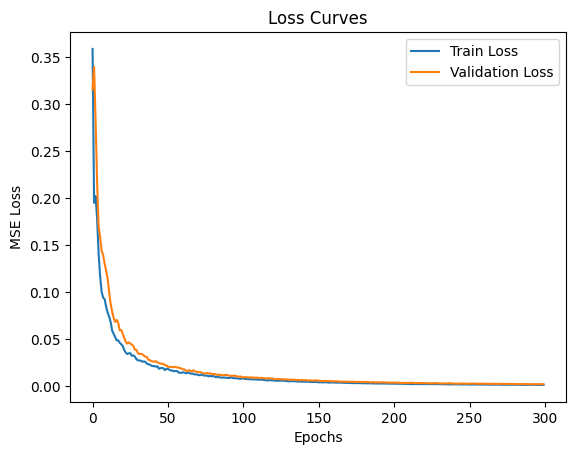

In [121]:
from matplotlib import pyplot as plt

plt.title('Loss Curves')
plt.plot(range(len(train_loss)), train_loss, label= 'Train Loss')
plt.plot(range(len(val_loss)), val_loss, label= 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

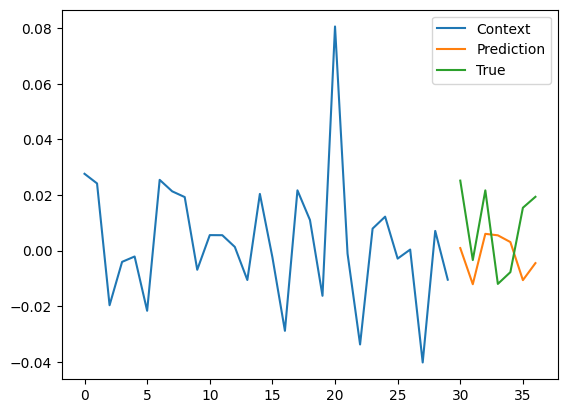

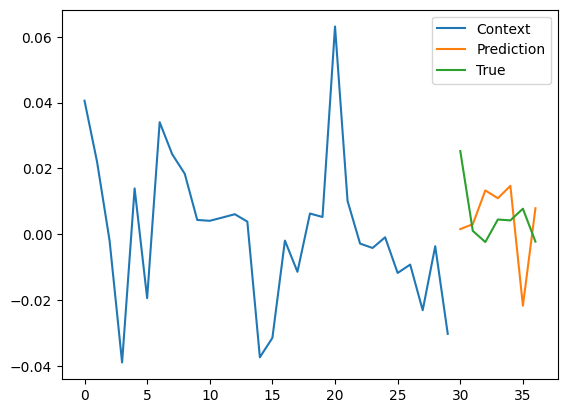

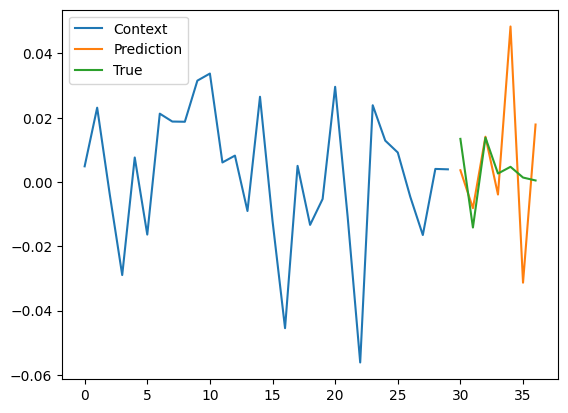

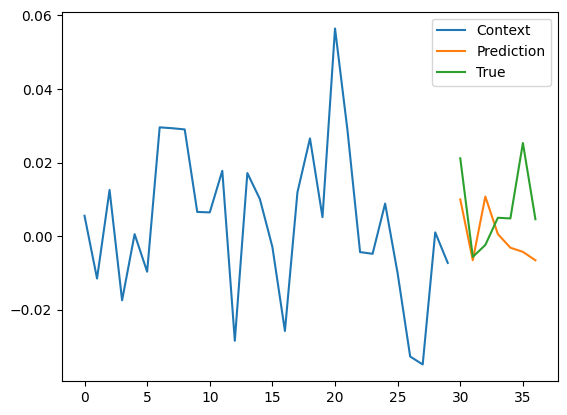

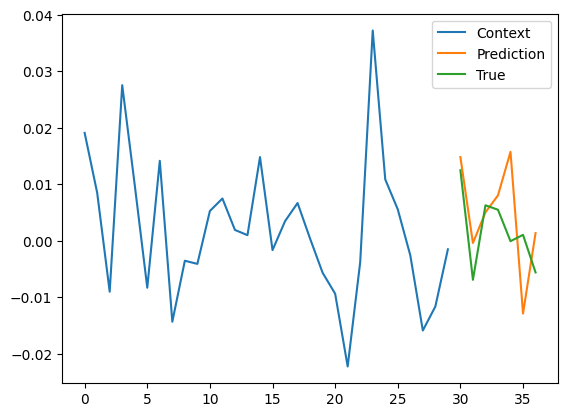

In [133]:
import torch

# Iterate over stocks to plot
for j in range(5):  # Plot 5 different stocks
    all_preds_for_stock = []

    # Run 5 trials for this stock and accumulate predictions
    for trial in range(10):
        for batch in valid_dl:
            x = batch[:, :, :window_size, :]
            y = batch[:, :, window_size:, 3].reshape(-1, horizon)
            x = x.to(device)

            with torch.no_grad():
                preds = net(x, Adj).T
                preds = preds.to('cpu')[j].squeeze()

            # Accumulate this trial's prediction
            all_preds_for_stock.append(preds)

            break  # Only first batch

    # Average the 5 predictions for this stock
    avg_preds = torch.stack(all_preds_for_stock).mean(dim=0)

    # Get the true values and context (using last batch data)
    y = y[j].squeeze()
    x = x[:, j, :, 3].squeeze().to('cpu')

    # Plot
    plt.figure()
    plt.plot(range(len(x)), x, label='Context')
    plt.plot(range(len(x), len(x) + len(avg_preds)), avg_preds, label='Prediction')
    plt.plot(range(len(x), len(x) + len(y)), y, label='True')
    plt.legend()
    plt.show()

    # Clear for next stock
    all_preds_for_stock = []


In [123]:
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)

Number of parameters: 2286247 (2.29 million)


In [138]:
def build_pred_actual_df(net, valid_dl, Adj, device, window_size, horizon, num_stocks=5, trials=10):
    records = []  # will store dict rows for DF

    all_trial_preds = []  # shape will be (trials, num_stocks, horizon)

    # collect predictions across trials for ALL stocks at once
    for _ in range(trials):
        for batch in valid_dl:
            x = batch[:, :, :window_size, :].to(device)
            y = batch[:, :, window_size:, 3].reshape(-1, horizon)

            with torch.no_grad():
                preds = net(x, Adj).T.to('cpu')  # shape: (num_stocks, horizon)

            all_trial_preds.append(preds[:num_stocks])  # keep only first num_stocks
            break  # only first batch

    # average preds across trials: (trials, num_stocks, horizon) -> (num_stocks, horizon)
    avg_preds = torch.stack(all_trial_preds).mean(dim=0)

    # actual values for all stocks: (num_stocks, horizon)
    actual = y[:num_stocks].cpu()

    # build records for all stocks
    for stock_id in range(num_stocks):
        for t in range(horizon):
            records.append({
                "stock_id": stock_id,
                "time_step": t,
                "actual": float(actual[stock_id, t]),
                "predicted": float(avg_preds[stock_id, t])
            })

    return pd.DataFrame(records)

df_pred = build_pred_actual_df(
    net=net,
    valid_dl=valid_dl,
    Adj=Adj,
    device=device,
    window_size=window_size,
    horizon=horizon,
    num_stocks=492,  
    trials=10
)

df_pred

,stock_id,time_step,actual,predicted
0,0,0,0.025154,0.000887
1,0,1,-0.003415,-0.012116
2,0,2,0.021645,0.006010
3,0,3,-0.012006,0.005476
4,0,4,-0.007773,0.003052
...,...,...,...,...
3439,491,2,0.010520,-0.001041
3440,491,3,0.008915,0.007243
3441,491,4,0.004685,0.002923
3442,491,5,0.005194,-0.026262


In [139]:
df_pred.to_csv('df_pred.csv')

In [136]:
# Save entire model
torch.save(net, 'graph_transformer_full_model.pth')

# To load it later:
net = torch.load('graph_transformer_full_model.pth',weights_only=False)
net.eval()

GT(
  (node_emb): ModuleList(
    (0-4): 5 x ConvNN(
      (conv): Sequential(
        (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
        (1): ReLU()
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
        (4): ReLU()
        (5): Flatten(start_dim=1, end_dim=-1)
        (6): Linear(in_features=832, out_features=128, bias=True)
      )
    )
  )
  (Node_Embeddings): Embedding(492, 128)
  (Edge_Embeddings): Embedding(4, 128)
  (BlockGT_encoder_layers): ModuleList(
    (0-3): 4 x BlockGT(
      (LNx): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (LNx2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (MLPx): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
      (MHA): MHA(
        (heads): ModuleList(
          (0-7): 8 x head_att